# Prediksi Churn Pelanggan Telekomunikasi  
## Logistic Regression vs XGBoost (End-to-End)

**Dataset:** Telco Customer Churn (Kaggle)  
- File umum: `WA_Fn-UseC_-Telco-Customer-Churn.csv`  
- Link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

> Jalankan cell secara berurutan. Notebook ini mencakup: load data → cleaning → EDA (grafik) → preprocessing → modeling (2 model) → evaluasi (grafik) → komparasi → feature importance → simpan model untuk deployment Streamlit.


## 0. Persiapan & Instalasi (jika perlu)
Jika kamu memakai Google Colab, jalankan cell instalasi berikut. Jika sudah ada library di laptop, boleh dilewati.


In [1]:
# Jika di Colab: jalankan instalasi ini
!pip -q install xgboost joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    f1_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import joblib


## 1. Load Dataset
Pastikan file CSV sudah ada di folder kerja notebook (upload ke Colab / letakkan di folder project).


In [2]:
# Ganti path jika perlu
DATA_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Informasi dataset (tipe data & ringkasan)

In [3]:
df.info()
df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning & Persiapan Target
- Drop `customerID` karena hanya identifier dan tidak membantu prediksi.
- `TotalCharges` sering terbaca sebagai teks karena ada nilai spasi → dikonversi ke numerik.
- Target `Churn` (Yes/No) → (1/0).


In [4]:
# Rapikan nama kolom (opsional)
df.columns = [c.strip() for c in df.columns]

# Konversi TotalCharges ke numerik (akan menghasilkan NaN jika ada nilai kosong/spasi)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Target: Churn Yes/No -> 1/0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Drop kolom ID
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

print(df.dtypes)
print("\nMissing values (top 10):")
df.isna().sum().sort_values(ascending=False).head(10)


gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Missing values (top 10):


TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
dtype: int64

## 3. EDA Singkat (dengan grafik)
Fokus EDA:
1. Distribusi target churn (cek imbalance).
2. Grafik tambahan: rata-rata tenure vs churn, rata-rata MonthlyCharges vs churn, dan boxplot MonthlyCharges vs churn.


Churn rate: 26.54%


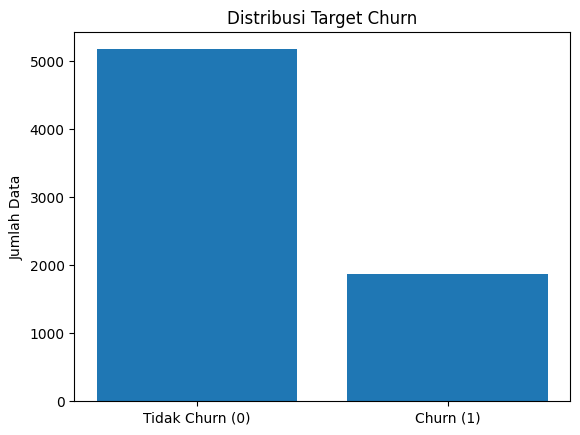

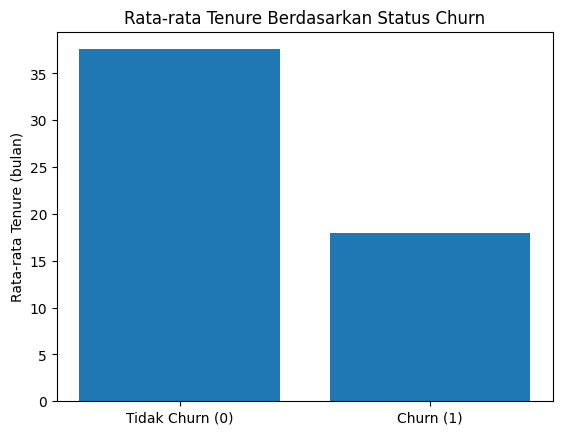

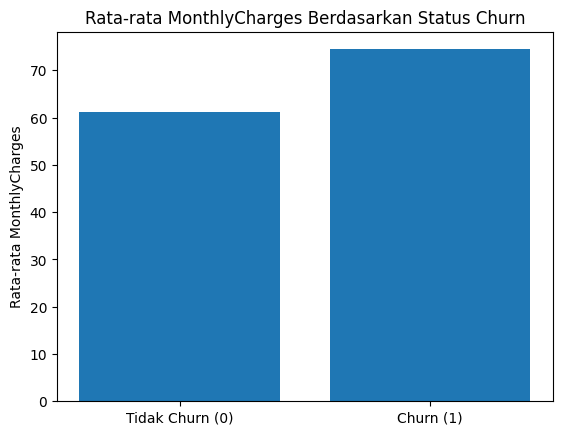

In [5]:
# Distribusi target
churn_rate = df["Churn"].mean()
print(f"Churn rate: {churn_rate:.2%}")

counts = df["Churn"].value_counts().sort_index()
labels = ["Tidak Churn (0)", "Churn (1)"]

plt.figure()
plt.bar(labels, counts.values)
plt.title("Distribusi Target Churn")
plt.ylabel("Jumlah Data")
plt.show()

# 1) Rata-rata tenure berdasarkan churn
if "tenure" in df.columns:
    mean_tenure = df.groupby("Churn")["tenure"].mean()

    plt.figure()
    plt.bar(["Tidak Churn (0)", "Churn (1)"], mean_tenure.values)
    plt.title("Rata-rata Tenure Berdasarkan Status Churn")
    plt.ylabel("Rata-rata Tenure (bulan)")
    plt.show()
else:
    print("Kolom 'tenure' tidak ditemukan.")

# 2) Rata-rata MonthlyCharges berdasarkan churn
if "MonthlyCharges" in df.columns:
    mean_monthly = df.groupby("Churn")["MonthlyCharges"].mean()

    plt.figure()
    plt.bar(["Tidak Churn (0)", "Churn (1)"], mean_monthly.values)
    plt.title("Rata-rata MonthlyCharges Berdasarkan Status Churn")
    plt.ylabel("Rata-rata MonthlyCharges")
    plt.show()
else:
    print("Kolom 'MonthlyCharges' tidak ditemukan.")


## 4. Split X/y dan Train/Test
Menggunakan `stratify=y` agar proporsi churn di train/test tetap mirip (karena data biasanya imbalanced).


In [6]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())


Train shape: (5634, 19) Test shape: (1409, 19)
Train churn rate: 0.2653532126375577 Test churn rate: 0.2654364797728886


## 5. Identifikasi Fitur Numerik vs Kategorikal

In [7]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Num numeric:", len(numeric_features))
print("Num categorical:", len(categorical_features))


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Num numeric: 4
Num categorical: 15


## 6. Preprocessing Pipeline (WAJIB)
Agar aman untuk deployment, preprocessing digabung dalam pipeline:
- Numerik: imputasi median + scaling (median tahan outlier).
- Kategorikal: imputasi modus + one-hot encoding (agar kategori jadi numerik).


In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


## 7. Model 1 — Logistic Regression (Baseline)
Evaluasi utama: **F1-score** (karena data imbalanced). Tambahan: ROC-AUC.


== Logistic Regression ==
F1-score: 0.6040462427745664
ROC-AUC: 0.8418610659019866

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix:
 [[926 109]
 [165 209]]


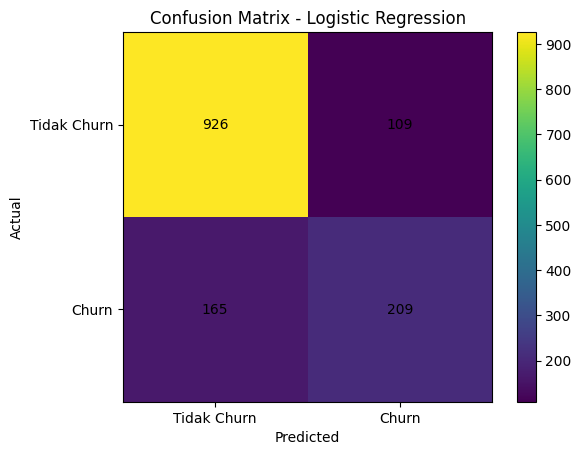

In [9]:
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

pipe_lr.fit(X_train, y_train)

pred_lr = pipe_lr.predict(X_test)
proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

f1_lr = f1_score(y_test, pred_lr)
auc_lr = roc_auc_score(y_test, proba_lr)

print("== Logistic Regression ==")
print("F1-score:", f1_lr)
print("ROC-AUC:", auc_lr)
print("\nClassification Report:\n", classification_report(y_test, pred_lr))

cm_lr = confusion_matrix(y_test, pred_lr)
print("Confusion Matrix:\n", cm_lr)

plt.figure()
plt.imshow(cm_lr)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Tidak Churn", "Churn"])
plt.yticks([0, 1], ["Tidak Churn", "Churn"])

for (i, j), v in np.ndenumerate(cm_lr):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()


## 8. Model 2 — XGBoost (Advanced)
Menambahkan `scale_pos_weight` untuk membantu penanganan data imbalanced.


== XGBoost ==
F1-score: 0.6247288503253796
ROC-AUC: 0.8403123304657832

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.77      1409

Confusion Matrix:
 [[775 260]
 [ 86 288]]


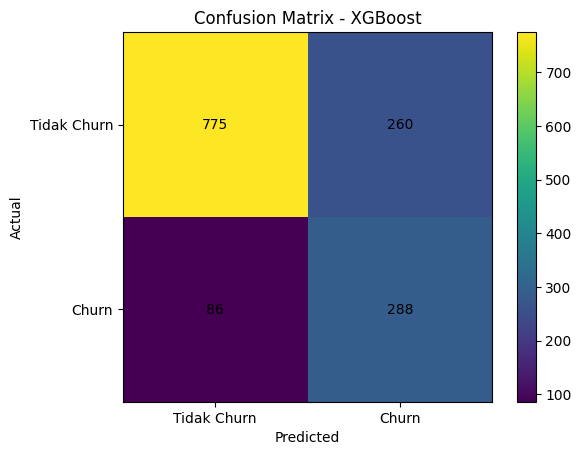

In [10]:
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)

pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    ))
])

pipe_xgb.fit(X_train, y_train)

pred_xgb = pipe_xgb.predict(X_test)
proba_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

f1_xgb = f1_score(y_test, pred_xgb)
auc_xgb = roc_auc_score(y_test, proba_xgb)

print("== XGBoost ==")
print("F1-score:", f1_xgb)
print("ROC-AUC:", auc_xgb)
print("\nClassification Report:\n", classification_report(y_test, pred_xgb))

cm_xgb = confusion_matrix(y_test, pred_xgb)
print("Confusion Matrix:\n", cm_xgb)

plt.figure()
plt.imshow(cm_xgb)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Tidak Churn", "Churn"])
plt.yticks([0, 1], ["Tidak Churn", "Churn"])

for (i, j), v in np.ndenumerate(cm_xgb):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()


## 9. ROC Curve (Grafik)
ROC curve membantu melihat trade-off TPR vs FPR, dan ROC-AUC sebagai ringkasan performa.


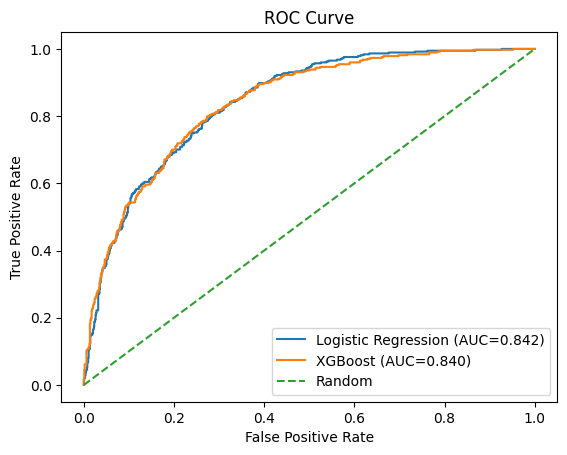

In [11]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## 10. Komparasi & Pilih Model Terbaik
Memilih model terbaik berdasarkan F1-score (utama untuk data imbalanced).


In [12]:
results = pd.DataFrame([
    {"Model": "Logistic Regression", "F1": f1_lr, "ROC_AUC": auc_lr},
    {"Model": "XGBoost", "F1": f1_xgb, "ROC_AUC": auc_xgb},
]).sort_values("F1", ascending=False)

results


,Model,F1,ROC_AUC
1,XGBoost,0.624729,0.840312
0,Logistic Regression,0.604046,0.841861


### Grafik perbandingan F1-score

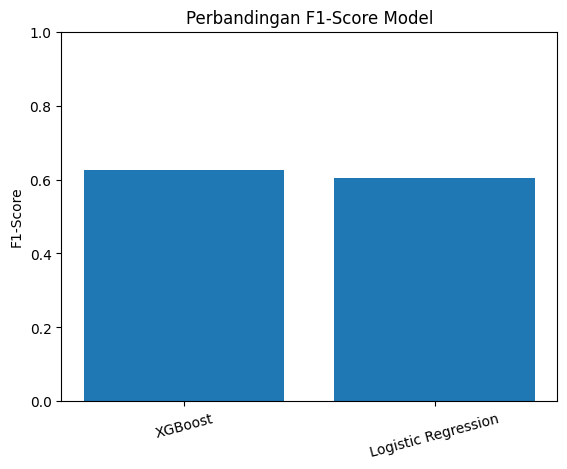

In [13]:
plt.figure()
plt.bar(results["Model"], results["F1"])
plt.title("Perbandingan F1-Score Model")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()


## 11. Feature Importance (untuk laporan)
Jika model terbaik adalah XGBoost, tampilkan Top 10 feature importance.


Model terbaik: XGBoost


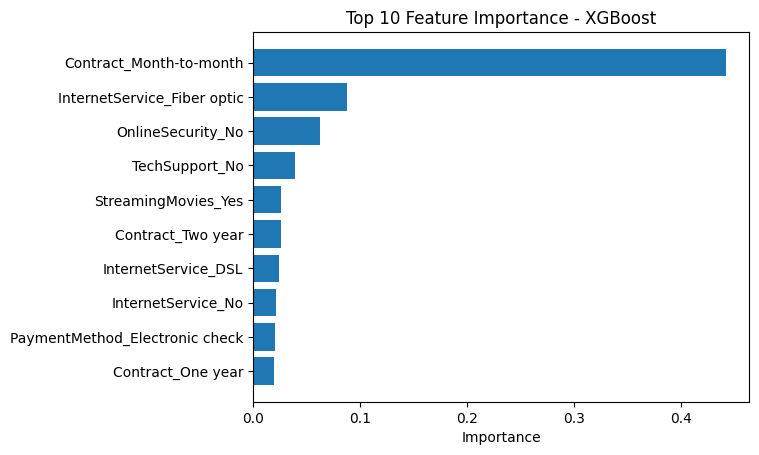

In [14]:
best_pipe = pipe_xgb if f1_xgb >= f1_lr else pipe_lr
best_name = "XGBoost" if best_pipe is pipe_xgb else "LogisticRegression"
print("Model terbaik:", best_name)

if best_name == "XGBoost":
    ohe = best_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_feature_names])

    importances = best_pipe.named_steps["model"].feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(10)

    fi

    plt.figure()
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("Top 10 Feature Importance - XGBoost")
    plt.xlabel("Importance")
    plt.show()
else:
    print("Model terbaik bukan XGBoost, feature importance tidak ditampilkan.")


## 12. Simpan Model untuk Deployment Streamlit
Simpan **pipeline lengkap** (preprocessing + model) agar input dari aplikasi web aman.

Output file: `best_churn_model.joblib`


In [15]:
MODEL_PATH = "best_churn_model.joblib"
joblib.dump(best_pipe, MODEL_PATH)
print("Saved to:", MODEL_PATH)


Saved to: best_churn_model.joblib


## 13. Uji Prediksi 1 Sampel
Untuk memastikan model bisa dipakai di Streamlit, coba prediksi 1 baris data.


In [16]:
sample = X_test.iloc[[0]].copy()
pred = best_pipe.predict(sample)[0]
proba = best_pipe.predict_proba(sample)[0][1]

print("Sample input:")
sample

print("Prediksi (0=Tidak churn, 1=Churn):", int(pred))
print("Probabilitas churn:", float(proba))


Sample input:
Prediksi (0=Tidak churn, 1=Churn): 0
Probabilitas churn: 0.01724991388618946
